# Synthetic data test: Try different structural indices

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

In [2]:
region = [0, 35e3, 0, 25e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=1000)
inclination, declination = 35, -5
base_level = 100
noise_level = 5
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
true_coordinates = (15e3, 10e3, 0e3)

In [3]:
datasets = {}

## Dipole

In [4]:
magnetic_field = hm.dipole_magnetic(
    coordinates, 
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(1e10, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, noise_level, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["dipole"] = data

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


## Pipe

In [5]:
size = 50
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - size, 
        true_coordinates[0] + size, 
        true_coordinates[1] - size, 
        true_coordinates[1] + size, 
        true_coordinates[2] - 15e3, 
        true_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(1500, 90, 0),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, noise_level, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["pipe"] = data

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


## Dike

In [6]:
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - 50e3, 
        true_coordinates[0] + 50e3, 
        true_coordinates[1] - 100, 
        true_coordinates[1] + 100, 
        true_coordinates[2] - 7e3, 
        true_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(40, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, noise_level, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["dike"] = data

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


## Line

In [7]:
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - 50, 
        true_coordinates[0] + 50, 
        true_coordinates[1] - 50e3, 
        true_coordinates[1], 
        true_coordinates[2] - 50, 
        true_coordinates[2] + 50, 
    ],
    magnetization=hm.magnetic_angles_to_vec(1000, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, noise_level, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

datasets["line"] = data

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


## Plot the data

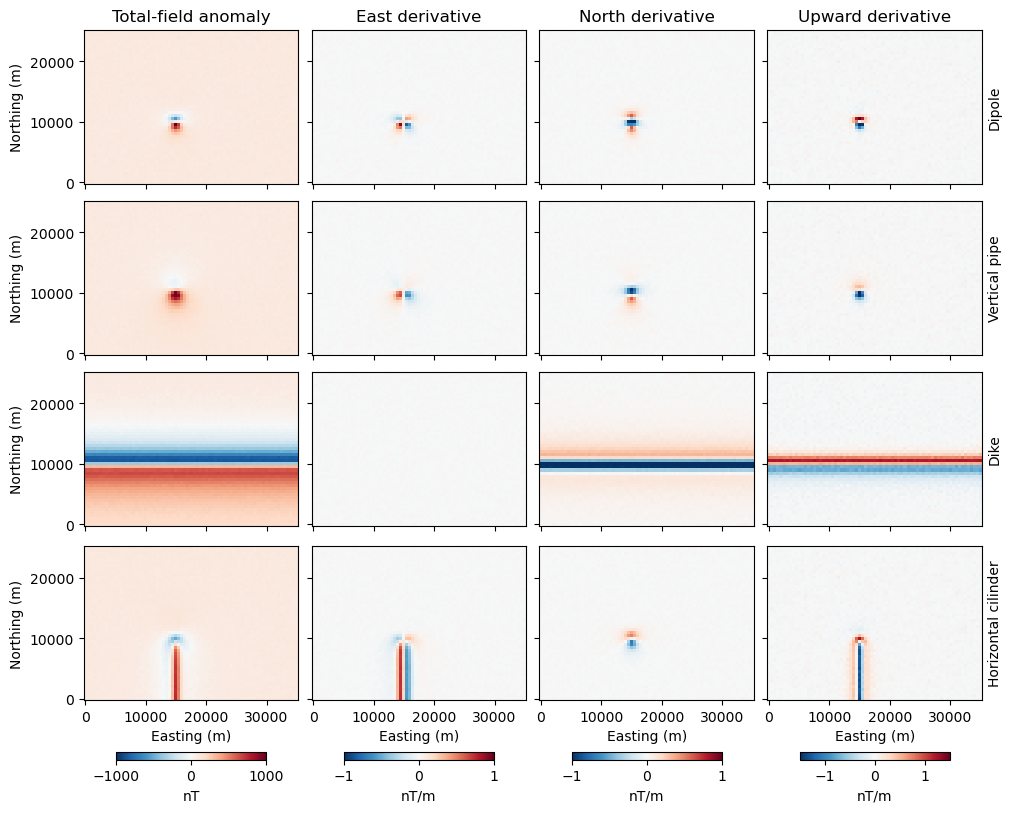

In [8]:
model_names = {"dipole": "Dipole", "line": "Horizontal cilinder", "pipe": "Vertical pipe", "dike": "Dike"}
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
scale = {"field": 1000, "deriv_east": 1, "deriv_north": 1, "deriv_up": 1.5}
titles = {"field": "Total-field anomaly", "deriv_east": "East derivative", "deriv_north": "North derivative", "deriv_up": "Upward derivative"}

fig, axes = plt.subplots(4, 4, figsize=(10, 8), layout='constrained', sharex=True, sharey=True)
for i, model in enumerate(datasets):
    for field, ax in zip(titles, axes[i, :].ravel()):
        if i == axes.shape[0] - 1:
            kwargs = dict(add_colorbar=True, cbar_kwargs=dict(orientation="horizontal", aspect=20, shrink=0.7, label=units[field]))
        else:
            kwargs = dict(add_colorbar=False)
        datasets[model][field].plot.pcolormesh(ax=ax, add_labels=False, cmap="RdBu_r", vmin=-scale[field], vmax=scale[field], **kwargs)
        ax.set_aspect("equal")
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Easting (m)")
for ax, model in zip(axes[:, -1], datasets):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model_names[model])
for ax, field in zip(axes[0, :], titles):
    ax.set_title(titles[field])
plt.show()

## Run Euler Inversion

In [9]:
structural_indices = [1, 2, 3]
rmse = {}

In [10]:
model = "dipole"
data = datasets[model]
rmse[model] = []
for si in structural_indices:    
    ei = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={ei.data_misfit_[-1]} | Position={ei.source_location_}")
    rmse[model].append(ei.data_misfit_[-1])

SI=1 | RMSE=0.8570882813117249 | Position=[15012.70919984 10037.48983513   609.4585039 ]
SI=2 | RMSE=0.4604133052477849 | Position=[15000.40292757 10014.7552725    263.69293284]
SI=3 | RMSE=0.3847642515325086 | Position=[14998.32245657 10005.6163173   -120.50329278]


In [11]:
model = "line"
data = datasets[model]
rmse[model] = []
for si in structural_indices:    
    ei = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={ei.data_misfit_[-1]} | Position={ei.source_location_}")
    rmse[model].append(ei.data_misfit_[-1])

SI=1 | RMSE=0.4281683431519446 | Position=[15009.34955299 10005.98747855   391.09310232]
SI=2 | RMSE=0.28960954616614504 | Position=[15002.7374521   9998.14969934   -79.24383945]
SI=3 | RMSE=0.3568747474005064 | Position=[15004.31391654 10027.64921763  -611.57056702]


In [12]:
model = "pipe"
data = datasets[model]
rmse[model] = []
for si in structural_indices:    
    ei = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={ei.data_misfit_[-1]} | Position={ei.source_location_}")
    rmse[model].append(ei.data_misfit_[-1])

SI=1 | RMSE=0.7095990147619949 | Position=[14999.83031537 10086.28284483   477.74561204]
SI=2 | RMSE=0.4076543769251144 | Position=[14996.28246457  9996.46763196   -72.14365796]
SI=3 | RMSE=0.4718991431068832 | Position=[14993.80125786  9988.45494275  -770.00945864]


In [13]:
model = "dike"
data = datasets[model]
rmse[model] = []
for si in structural_indices:    
    ei = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={ei.data_misfit_[-1]} | Position={ei.source_location_}")
    rmse[model].append(ei.data_misfit_[-1])

SI=1 | RMSE=0.12500605275477109 | Position=[ 1.61405598e+04  1.00049747e+04 -1.21529348e+01]
SI=2 | RMSE=0.16771502983863204 | Position=[15186.94500426  9998.22690573  -960.86400379]
SI=3 | RMSE=0.2098888796130976 | Position=[12611.90111875  9995.54145288 -2113.23468342]


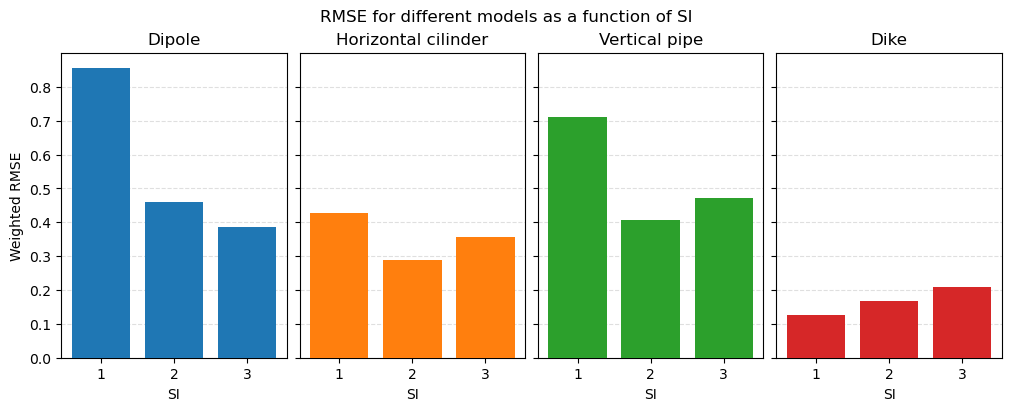

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout="constrained", sharey=True)
fig.suptitle("RMSE for different models as a function of SI")
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for ax, model, color in zip(axes.ravel(), rmse, colors):
    ax.bar(structural_indices, rmse[model], color=color, zorder=1000)
    ax.grid(axis="y", alpha=0.4, linestyle="--")
    ax.set_title(model_names[model])
    ax.set_xlabel("SI")
axes[0].set_ylabel("Weighted RMSE")
plt.show()